# Analyze Visitor Movement Based on Estimated Occupancies in Three Interest Areas
This note shows how do we roughly estimate the trendency of visitors' movement based on estimations of occupancy in Three Interest Areas.

* To understand how do we divide video frames into Three Interest Areas which include Whole Interest Area, Core Interest Area and Margin Interest Area, please refer to [Video Processing: Division of Three Interest Areas](./Video%20Processing%20Division%20of%20Three%20Interest%20Areas.ipynb).
* To have a look on how do we use Openpose to get estimations of coccupancy, please refer to [Occupancy Estimation: Single Analysis for Three Interest Areas](./Occupancy%20Estimation%20Single%20Analysis%20for%20Three%20Interest%20Areas.ipynb).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import math
from scipy.stats import mode
import cv2

# Load Estimation of Occupancy Calculated by Openpose

In [2]:
occupancy_whole = pd.read_csv('test_video_processed_occupancy_whole.csv', sep=',')
occupancy_core = pd.read_csv('test_video_processed_occupancy_core.csv', sep=',')
occupancy_margin = pd.read_csv('test_video_processed_occupancy_margin.csv', sep=',')

<IPython.core.display.Javascript object>


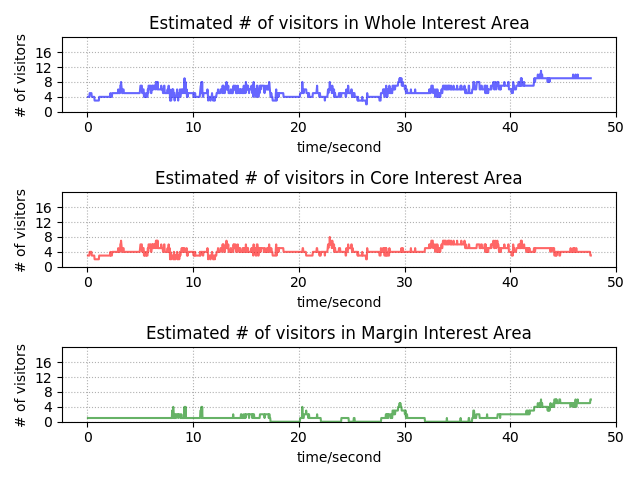

<IPython.core.display.Javascript object>


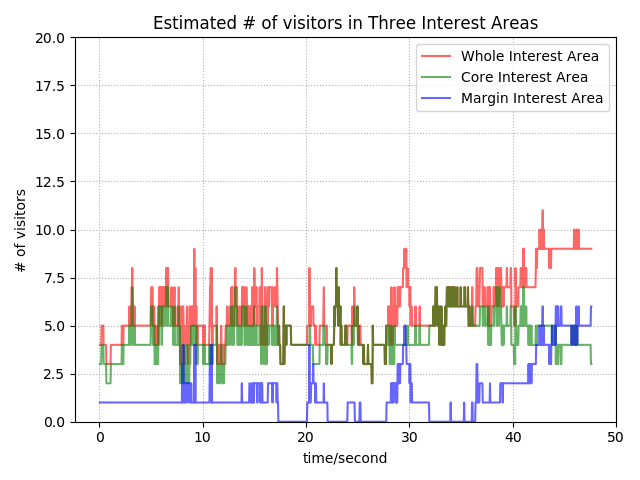

In [3]:
def subplot_estimated_occupancy(occupancy_whole, occupancy_core, occupancy_margin, fig_filename):
    """
    Plot and save estimated occupancy in Three Interest Area.
    Args:
        occupancy_whole (pd.DataFrame): occupancy in Whole Interest Area
        occupancy_core (pd.DataFrame): occupancy in Core Interest Area
        occupancy_margin (pd.DataFrame): occupancy in Margin Interest Area
        fig_filename (string): filename of the saved figure
    """
    ymin = 0
    ymax = 20
    ystep = 4
    lw=1.5
    plt.figure()
    # Whole Interest Area
    plt.subplot(3, 1, 1)
    plt.plot(occupancy_whole['Time']/1000, occupancy_whole['Occupancy'], 'b-', lw, alpha=0.6)
    plt.xlabel('time/second')
    plt.ylabel('# of visitors')
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin,ymax,ystep))
    plt.title('Estimated # of visitors in Whole Interest Area')
    plt.grid(True, linestyle=':')

    # Core Interest Area
    plt.subplot(3, 1, 2)
    plt.plot(occupancy_core['Time']/1000, occupancy_core['Occupancy'], 'r-', lw, alpha=0.6)
    plt.xlabel('time/second')
    plt.ylabel('# of visitors')
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin,ymax,ystep))
    plt.title('Estimated # of visitors in Core Interest Area')
    plt.grid(True, linestyle=':')

    # Margin Interest Area
    plt.subplot(3, 1, 3)
    plt.plot(occupancy_margin['Time']/1000, occupancy_margin['Occupancy'], 'g-', lw, alpha=0.6)
    plt.xlabel('time/second')
    plt.ylabel('# of visitors')
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin,ymax,ystep))
    plt.title('Estimated # of visitors in Margin Interest Area')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    #plt.show()
    plt.savefig(fig_filename, dpi = 300)

def plot_estimated_occupancy(occupancy_whole, occupancy_core, occupancy_margin, fig_filename):
    ymin=0
    ymax=20
    ystep=4
    
    plt.figure()
    # Whole Interest Area
    plt.plot(occupancy_whole['Time']/1000, occupancy_whole['Occupancy'], 'r-', lw=1.5, alpha=0.6)
    # Core Interest Area
    plt.plot(occupancy_core['Time']/1000, occupancy_core['Occupancy'], 'g-', lw=1.5, alpha=0.6)
    # Margin Interest Area
    plt.plot(occupancy_margin['Time']/1000, occupancy_margin['Occupancy'], 'b-', lw=1.5, alpha=0.6)
    plt.legend(('Whole Interest Area','Core Interest Area','Margin Interest Area'))

    plt.xlabel('time/second')
    plt.ylabel('# of visitors')
    plt.ylim(ymin, ymax, ystep)
    plt.title('Estimated # of visitors in Three Interest Areas')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()
    plt.savefig(fig_filename, dpi = 300)
    
fig_filename = 'Subplot_Estimated_Occupancy.png'
subplot_estimated_occupancy(occupancy_whole, occupancy_core, occupancy_margin, fig_filename)
fig_filename = 'Plot_Estimated_Occupancy.png'
plot_estimated_occupancy(occupancy_whole, occupancy_core, occupancy_margin, fig_filename)

## Compare Estimated Occupancy in Whole Interest Area and the Sum of Estimated Occupancies in Core and Margin Area 
The reason we show this is because previously we estimate occupancy independently in each of Three Interest Areas, which shows inconsistent results in where the sum of occupancy in Core and Margin Interest Area is not equal to the occupancy in Whole Interest area. However, in this version we infer occupancy from the number of visitors in Whole Interest Area and in Core Interest Area, which makes sure consistence.

<IPython.core.display.Javascript object>


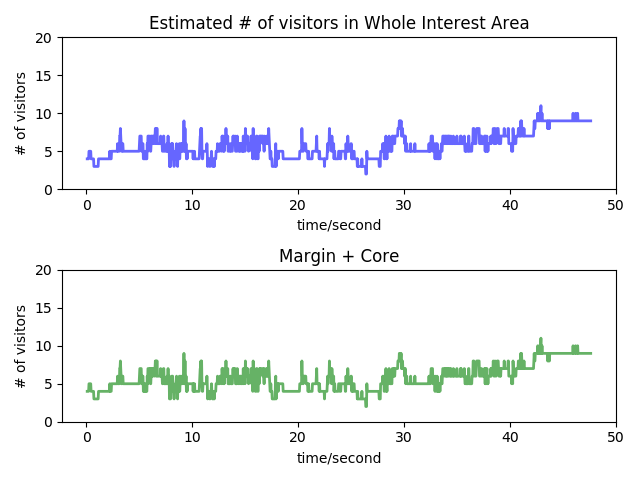

In [4]:
plt.figure()
# Whole Interest Area
plt.subplot(2,1,1)
plt.plot(occupancy_whole['Time']/1000, occupancy_whole['Occupancy'], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
# Margin + Core Interest Area
plt.subplot(2,1,2)
plt.plot(occupancy_margin['Time']/1000, occupancy_margin['Occupancy']+occupancy_core['Occupancy'], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')
#plt.grid(True)

plt.tight_layout()
plt.show()

The time interval between two estimates is around 33 millisedonds. Thus, if we assume people will stay at the same place within one second. We can average over a sliding window of size 30.

In [5]:
print('The time interval between two estimates: {} milliseconds'.format(occupancy_whole['Time'][1]-occupancy_whole['Time'][0]))

The time interval between two estimates: 33.3326330532213 milliseconds


# Smoothen Estimations of # of Visitors in Three Areas calculated by Openpose

## Sliding Window Smoothing Method (self-defined)

In [6]:
import pdb
def moving_smoothing(values, window_size, smooth_type='mode', stride = 1):
    """
    Smoothen estimated occupancy.
    Args:
        values (pandas.DataFrame): 
            values['Time']: time in millisecond
            values['Occupancy']: estimated # of visitors
        window_size(int): the size of sliding window
        smooth_type (string): 
            1. 'mode'
            2. 'mean'
            3. 'min'
            4. 'median'
        stride (int): the stride between two consecutive windows
    Returns:
        smooth_time (np.array): smooth time i.e. the max time in each window
        smooth_occupancy (np.array): smooth occupancy i.e. the mode occupancy in each window
    """
    group_time = []
    group_occupancy = []
    for i in range(0, math.ceil((len(values['Time'])-window_size+1)/stride)):
        group_time.append(values['Time'][i:i+window_size])
        group_occupancy.append(values['Occupancy'][i:i+window_size])
    
    smooth_time = []
    smooth_occupancy = []
    for i in range(len(group_time)):
        smooth_time.append(min(group_time[i])) # max time in the group
        if smooth_type == 'mode':
            smooth_occupancy.append(mode(group_occupancy[i])[0][0]) # mode occupancy in the group
        elif smooth_type == 'mean':
            smooth_occupancy.append(np.round(np.mean(group_occupancy[i])))
        elif smooth_type == 'min':
            smooth_occupancy.append(np.round(np.min(group_occupancy[i])))
        elif smooth_type == 'median':
            smooth_occupancy.append(np.round(np.median(group_occupancy[i])))
        else:
            print('Please choose a proper smooth_type.')
    smooth_values = pd.DataFrame(data={'Time': np.array(smooth_time),
                                       'Occupancy': np.array(smooth_occupancy,dtype=int)})
    return smooth_values#np.array(smooth_time), np.array(smooth_occupancy)

In [43]:
window_size = 15
smooth_type='median'
stride = 1

<IPython.core.display.Javascript object>


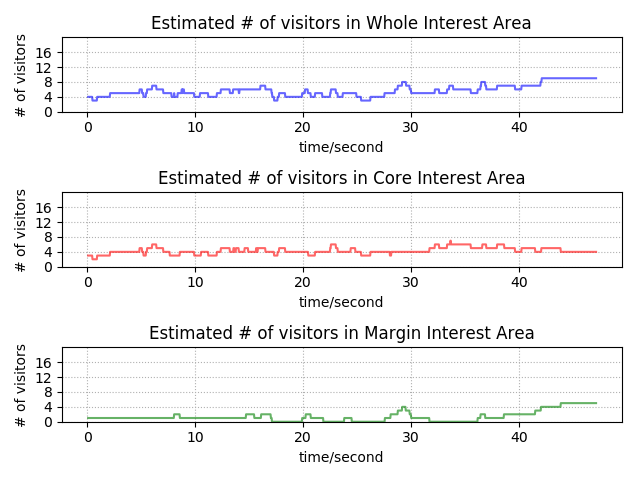

<IPython.core.display.Javascript object>


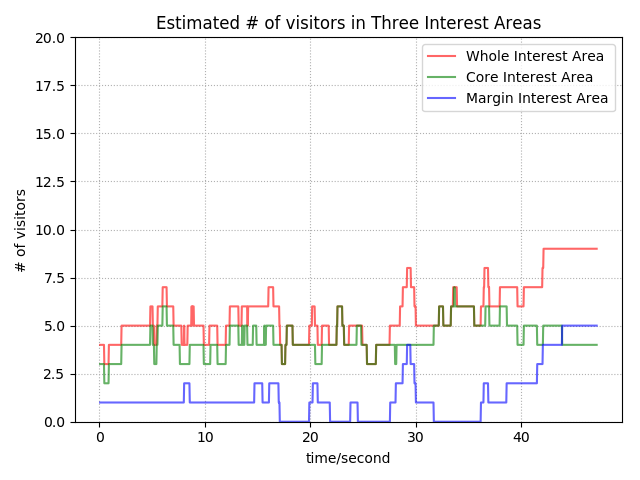

In [44]:
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

fig_filename = 'Subplot_Smooth_Estimated_Occupancy.png'
subplot_estimated_occupancy(smooth_occupancy_whole,smooth_occupancy_core,smooth_occupancy_margin, fig_filename)
fig_filename = 'Plot_Smooth_Estimated_Occupancy.png'
plot_estimated_occupancy(smooth_occupancy_whole,smooth_occupancy_core,smooth_occupancy_margin, fig_filename)

### Compare
1. subplot 1: First add seperate estimations of core and margin, then smoothen
2. subplot 2: First smoothen estimateions of core and margin seperatively, then add smoothened estimations together.

<IPython.core.display.Javascript object>


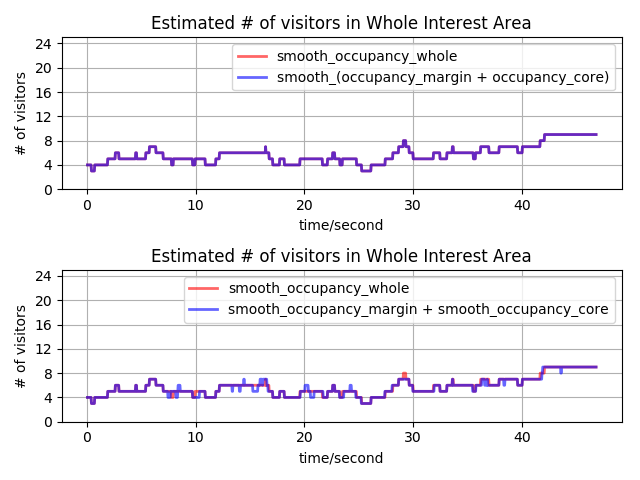

In [9]:
plt.figure()

# Add then Smoothen
plt.subplot(2,1,1)
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
occupancy_margin_add_core = occupancy_whole
occupancy_margin_add_core['Occupancy'] = occupancy_core['Occupancy'] + occupancy_margin['Occupancy']
smooth_occupancy_margin_add_core = moving_smoothing(occupancy_margin_add_core, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_occupancy_whole['Time']/1000, smooth_occupancy_whole['Occupancy'], 'r-', lw=2, alpha=0.6)
# Core and Margin Interest Area
plt.plot(smooth_occupancy_margin_add_core['Time']/1000, smooth_occupancy_margin_add_core['Occupancy'], 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

# Smoothen then Add
plt.subplot(2,1,2)
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_occupancy_whole['Time']/1000, smooth_occupancy_whole['Occupancy'], 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_occupancy_core['Time']/1000, smooth_occupancy_core['Occupancy']+smooth_occupancy_margin['Occupancy'], 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/second')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze Visitors' Movement

## Senario Truth Value Table

Assumption: 
1. There is a time-delay for visitors to move from one area to another area.
2. At the same time step: z = x+y
3. Estimate of # of visitors in each area is independent from each other.

**First three columns** correspond the variation tendency of the number of visitors in three area i.e. Core, Margin and Whole Interest Area. 
The codes for three variation tendencies are:
* 0: hold
* 1: increase
* 2: decrease

The **forth column** indicates whether the senario possible in reality assuming the estimates of the number of visitors in three areas are accurate. Sepcifically,
* 0: impossible senario
* 1: possible senarios

The **fifth column** gives [explanation on the senario](https://github.com/UWaterloo-ASL/Openpose-Video-Analysis/blob/master/docs/Truth%20Value%20Table.pdf).

* 27 combinations
   * only 13 of 27 combinations are possible
      * only 4 of the 13 possible cases in where new visitors come in.
      * only 6 of the 13 possible cases in where visitors leave from the whole interest area.
      * Only 3 of the 13 possible cases in where the # of visitors remain unchanged.

If we have this Truth Table, and we can estimate the change of the # of visitors in each area of two consecutive time steps, we can infer which scenario is happening.


In [10]:
senarios_truth_table = pd.read_csv('analize_visitor_in_and_out_senario_truth_table.csv')
senarios_truth_table

,# of visitors in core area: x,# of visitors in margin: y,# of visitors in whole interest area: z,Truth value,Explanation
0,0,0,0,1,No people transform between space.
1,0,0,1,0,Impossible
2,0,0,2,0,Impossible
3,0,1,0,0,Impossible
4,0,1,1,1,New people come in
5,0,1,2,0,Impossible
6,0,2,0,0,Impossible
7,0,2,1,0,Impossible
8,0,2,2,1,People get out
9,1,0,0,0,Impossible


### Func to Interpret senario from occupancy estimations in Core, Margin and Whole Interest areas.

In [11]:
def interpret_senario(occupancy_whole, occupancy_core, occupancy_margin, senarios_truth_table):
    """
    Args:
        occupancy_whole (pd.DataFrame): estimation of coccupancy in whole intrest area
        occupancy_core (pd.DataFrame): estimation of coccupancy in core intrest area
        occupancy_margin (pd.DataFrame): estimation of coccupancy in margin intrest area
        senarios_truth_table (pandas.DataFrame): senarios truth table which has information on
            how to interpret senario.
    Returns:
        senario_sequence (np.array): sequnce of interpreted senario discription according to "Senario Truth Value Table"
        event_sequence (np.array): sequence of interpreted senario code according to "Senario Truth Value Table"
            Note: Different from "Senario Truth Value Table", in this sequence we convert all impossible cases into 0 rather than their original senario code.
        event_time (np.array): the time of each event in millisecond.
    """
    senario_sequence = []
    event_sequence = []
    event_time = []
    for i in range(len(occupancy_whole['Occupancy'])-1):
        change_x = occupancy_core['Occupancy'][i+1] - occupancy_core['Occupancy'][i]
        change_y = occupancy_margin['Occupancy'][i+1] - occupancy_margin['Occupancy'][i]
        change_z = occupancy_whole['Occupancy'][i+1] - occupancy_whole['Occupancy'][i]
        # code: 
        #    0: hold
        #    1: increase
        #    2: decrease
        if change_x == 0:
            x = 0
        elif change_x > 0:
            x = 1
        elif change_x < 0:
            x = 2

        if change_y == 0:
            y = 0
        elif change_y > 0:
            y = 1
        elif change_y < 0:
            y = 2

        if change_z == 0:
            z = 0
        elif change_z > 0:
            z = 1
        elif change_z < 0:
            z = 2
        # convert ternary to decimal
        senario_index = z + y*3 + x*3^2
        senario_sequence.append(senarios_truth_table['Explanation'][senario_index])
        if senarios_truth_table['Truth value'][senario_index] == 0:
            # convert all impossible cases into 0
            event_sequence.append(0)
            #event_sequence.append(senario_index)
        else:
            event_sequence.append(senario_index)
        event_time.append(occupancy_whole['Time'][i])
    return np.array(senario_sequence), np.array(event_sequence), np.array(event_time)

### Func to Plot Detected Interesting Event

In [12]:
def plot_detected_interesting_event(senario_sequence, event_sequence, event_time, fig_filename):
    ymin = 0
    ymax = 26.0005
    ystep = 1
    plt.figure(figsize=(10, 6))
    plt.scatter(event_time/1000, event_sequence)
    plt.xlabel('time/second')
    plt.ylabel('Event Description')
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin,ymax,ystep), senarios_truth_table['Explanation'],
               rotation=45, fontsize = 6)
    ax2 = plt.twinx()
    plt.ylabel('Event Code')
    plt.yticks(np.arange(ymin,ymax,ystep), np.arange(ymin,ymax,ystep))
    plt.title('Detected Interesting Events')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig(fig_filename, dpi = 300)

### Func to Tag Description of Interesting Envent on Video 

In [13]:
def tag_interesting_event_description_on_video(video_filename,
                                               smooth_type, window_size, stride,
                                               senario_sequence, event_sequence, event_time):
    """
    Args:
        video_filename (string): filename of video
        smooth_type (string): smooth type (hyper-parameter of smooth method)
        window_size (int): size of smooth window (hyper-parameter of smooth method)
        stride (int): stride size (hyper-parameter of smooth method)
        senario_sequence (np.array): sequnce of interpreted senario discription according to "Senario Truth Value Table"
        event_sequence (np.array): sequence of interpreted senario code according to "Senario Truth Value Table"
            Note: Different from "Senario Truth Value Table", in this sequence we convert all impossible cases into 0 rather than their original senario code.
        event_time (np.array): the time of each event in millisecond.
    """
    camera = cv2.VideoCapture(video_filename)
    (grabbed, frame) = camera.read()
    fheight, fwidth, channels= frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_tagged_camera_frame = cv2.VideoWriter(video_filename.split('.avi')[0]+'_tagged_smooth_type_{}_window_size_{}_stride_{}.avi'.format(smooth_type,window_size,stride),fourcc, camera.get(cv2.CAP_PROP_FPS), (fwidth,fheight))
    # loop over the frames of the video
    total_frame_number = camera.get(cv2.CAP_PROP_FRAME_COUNT)
    max_line_character_num = 60 # 60 characters each line
    detected_event_time = 0
    detected_event_senario = ''
    line_num = 1
    for frame_count in range(len(event_time)):
        if frame_count % 200 == 0:
            print('Processing frame: {}'.format(frame_count))
        (grabbed, frame) = camera.read()
        if grabbed == True:
            cv2.putText(frame, "smooth_type: {}, window_size: {}, stride: {}.".format(smooth_type,window_size,stride), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            time = camera.get(cv2.CAP_PROP_POS_MSEC) #Current position of the video file in milliseconds.
            event_index = frame_count
            if event_sequence[event_index] != 0: # 0 means 'impossible event'
                detected_event_time = time
                detected_event_senario = senario_sequence[event_index]
                cv2.putText(frame, "Detect Interesting Event at: {}s.".format(int(detected_event_time/1000)), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                line_num = np.ceil(len(detected_event_senario)/max_line_character_num)
                for i in range(int(line_num)):
                    if i < line_num:
                        cv2.putText(frame, "{}".format(detected_event_senario[i*max_line_character_num:(i+1)*max_line_character_num]), (10, 180+30*(i)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                    else:
                        cv2.putText(frame, "{}".format(detected_event_senario[i*max_line_character_num:end]), (10, 180+30*(i)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            else: # repeat text from last detected event
                cv2.putText(frame, "Detect Interesting Event at: {}s".format(int(detected_event_time/1000)), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                for i in range(int(line_num)):
                    if i < line_num:
                        cv2.putText(frame, "{}".format(detected_event_senario[i*max_line_character_num:(i+1)*max_line_character_num]), (10, 180+30*(i)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                    else:
                        cv2.putText(frame, "{}".format(detected_event_senario[i*max_line_character_num:end]), (10, 180+30*(i)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            # save processed videos
            out_tagged_camera_frame.write(frame)
        else:
            # Pass this frame if cannot grab an image.
            print('Frame: {}, grabbed={} and frame={}'.format(frame_count, grabbed, frame))


## Sliding Window Smoothing

### mean
To check the tagged video, please go to YouTube: [smooth_type='mean'
window_size = 25
stride = 10](https://youtu.be/HzpcUg4h6QU)

In [14]:
smooth_type='mean'
window_size = 25
stride = 10

<IPython.core.display.Javascript object>


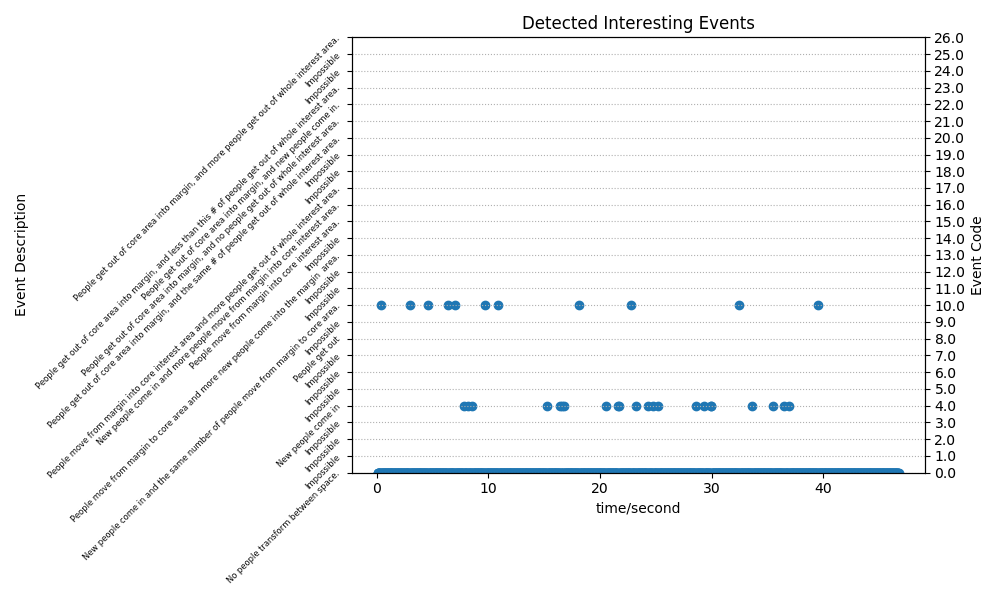

Processing frame: 0
Frame: 18, grabbed=False and frame=None
Frame: 19, grabbed=False and frame=None
Frame: 20, grabbed=False and frame=None
Frame: 21, grabbed=False and frame=None
Frame: 22, grabbed=False and frame=None
Frame: 23, grabbed=False and frame=None
Frame: 24, grabbed=False and frame=None
Frame: 25, grabbed=False and frame=None
Frame: 26, grabbed=False and frame=None
Frame: 27, grabbed=False and frame=None
Frame: 28, grabbed=False and frame=None
Frame: 29, grabbed=False and frame=None
Frame: 30, grabbed=False and frame=None
Frame: 31, grabbed=False and frame=None
Frame: 32, grabbed=False and frame=None
Frame: 33, grabbed=False and frame=None
Frame: 34, grabbed=False and frame=None
Frame: 35, grabbed=False and frame=None
Frame: 36, grabbed=False and frame=None
Frame: 37, grabbed=False and frame=None
Frame: 38, grabbed=False and frame=None
Frame: 39, grabbed=False and frame=None
Frame: 40, grabbed=False and frame=None
Frame: 41, grabbed=False and frame=None
Frame: 42, grabbed=F

Frame: 226, grabbed=False and frame=None
Frame: 227, grabbed=False and frame=None
Frame: 228, grabbed=False and frame=None
Frame: 229, grabbed=False and frame=None
Frame: 230, grabbed=False and frame=None
Frame: 231, grabbed=False and frame=None
Frame: 232, grabbed=False and frame=None
Frame: 233, grabbed=False and frame=None
Frame: 234, grabbed=False and frame=None
Frame: 235, grabbed=False and frame=None
Frame: 236, grabbed=False and frame=None
Frame: 237, grabbed=False and frame=None
Frame: 238, grabbed=False and frame=None
Frame: 239, grabbed=False and frame=None
Frame: 240, grabbed=False and frame=None
Frame: 241, grabbed=False and frame=None
Frame: 242, grabbed=False and frame=None
Frame: 243, grabbed=False and frame=None
Frame: 244, grabbed=False and frame=None
Frame: 245, grabbed=False and frame=None
Frame: 246, grabbed=False and frame=None
Frame: 247, grabbed=False and frame=None
Frame: 248, grabbed=False and frame=None
Frame: 249, grabbed=False and frame=None
Frame: 250, grab

Frame: 433, grabbed=False and frame=None
Frame: 434, grabbed=False and frame=None
Frame: 435, grabbed=False and frame=None
Frame: 436, grabbed=False and frame=None
Frame: 437, grabbed=False and frame=None
Frame: 438, grabbed=False and frame=None
Frame: 439, grabbed=False and frame=None
Frame: 440, grabbed=False and frame=None
Frame: 441, grabbed=False and frame=None
Frame: 442, grabbed=False and frame=None
Frame: 443, grabbed=False and frame=None
Frame: 444, grabbed=False and frame=None
Frame: 445, grabbed=False and frame=None
Frame: 446, grabbed=False and frame=None
Frame: 447, grabbed=False and frame=None
Frame: 448, grabbed=False and frame=None
Frame: 449, grabbed=False and frame=None
Frame: 450, grabbed=False and frame=None
Frame: 451, grabbed=False and frame=None
Frame: 452, grabbed=False and frame=None
Frame: 453, grabbed=False and frame=None
Frame: 454, grabbed=False and frame=None
Frame: 455, grabbed=False and frame=None
Frame: 456, grabbed=False and frame=None
Frame: 457, grab

Frame: 637, grabbed=False and frame=None
Frame: 638, grabbed=False and frame=None
Frame: 639, grabbed=False and frame=None
Frame: 640, grabbed=False and frame=None
Frame: 641, grabbed=False and frame=None
Frame: 642, grabbed=False and frame=None
Frame: 643, grabbed=False and frame=None
Frame: 644, grabbed=False and frame=None
Frame: 645, grabbed=False and frame=None
Frame: 646, grabbed=False and frame=None
Frame: 647, grabbed=False and frame=None
Frame: 648, grabbed=False and frame=None
Frame: 649, grabbed=False and frame=None
Frame: 650, grabbed=False and frame=None
Frame: 651, grabbed=False and frame=None
Frame: 652, grabbed=False and frame=None
Frame: 653, grabbed=False and frame=None
Frame: 654, grabbed=False and frame=None
Frame: 655, grabbed=False and frame=None
Frame: 656, grabbed=False and frame=None
Frame: 657, grabbed=False and frame=None
Frame: 658, grabbed=False and frame=None
Frame: 659, grabbed=False and frame=None
Frame: 660, grabbed=False and frame=None
Frame: 661, grab

Frame: 842, grabbed=False and frame=None
Frame: 843, grabbed=False and frame=None
Frame: 844, grabbed=False and frame=None
Frame: 845, grabbed=False and frame=None
Frame: 846, grabbed=False and frame=None
Frame: 847, grabbed=False and frame=None
Frame: 848, grabbed=False and frame=None
Frame: 849, grabbed=False and frame=None
Frame: 850, grabbed=False and frame=None
Frame: 851, grabbed=False and frame=None
Frame: 852, grabbed=False and frame=None
Frame: 853, grabbed=False and frame=None
Frame: 854, grabbed=False and frame=None
Frame: 855, grabbed=False and frame=None
Frame: 856, grabbed=False and frame=None
Frame: 857, grabbed=False and frame=None
Frame: 858, grabbed=False and frame=None
Frame: 859, grabbed=False and frame=None
Frame: 860, grabbed=False and frame=None
Frame: 861, grabbed=False and frame=None
Frame: 862, grabbed=False and frame=None
Frame: 863, grabbed=False and frame=None
Frame: 864, grabbed=False and frame=None
Frame: 865, grabbed=False and frame=None
Frame: 866, grab

Frame: 1044, grabbed=False and frame=None
Frame: 1045, grabbed=False and frame=None
Frame: 1046, grabbed=False and frame=None
Frame: 1047, grabbed=False and frame=None
Frame: 1048, grabbed=False and frame=None
Frame: 1049, grabbed=False and frame=None
Frame: 1050, grabbed=False and frame=None
Frame: 1051, grabbed=False and frame=None
Frame: 1052, grabbed=False and frame=None
Frame: 1053, grabbed=False and frame=None
Frame: 1054, grabbed=False and frame=None
Frame: 1055, grabbed=False and frame=None
Frame: 1056, grabbed=False and frame=None
Frame: 1057, grabbed=False and frame=None
Frame: 1058, grabbed=False and frame=None
Frame: 1059, grabbed=False and frame=None
Frame: 1060, grabbed=False and frame=None
Frame: 1061, grabbed=False and frame=None
Frame: 1062, grabbed=False and frame=None
Frame: 1063, grabbed=False and frame=None
Frame: 1064, grabbed=False and frame=None
Frame: 1065, grabbed=False and frame=None
Frame: 1066, grabbed=False and frame=None
Frame: 1067, grabbed=False and fra

Frame: 1246, grabbed=False and frame=None
Frame: 1247, grabbed=False and frame=None
Frame: 1248, grabbed=False and frame=None
Frame: 1249, grabbed=False and frame=None
Frame: 1250, grabbed=False and frame=None
Frame: 1251, grabbed=False and frame=None
Frame: 1252, grabbed=False and frame=None
Frame: 1253, grabbed=False and frame=None
Frame: 1254, grabbed=False and frame=None
Frame: 1255, grabbed=False and frame=None
Frame: 1256, grabbed=False and frame=None
Frame: 1257, grabbed=False and frame=None
Frame: 1258, grabbed=False and frame=None
Frame: 1259, grabbed=False and frame=None
Frame: 1260, grabbed=False and frame=None
Frame: 1261, grabbed=False and frame=None
Frame: 1262, grabbed=False and frame=None
Frame: 1263, grabbed=False and frame=None
Frame: 1264, grabbed=False and frame=None
Frame: 1265, grabbed=False and frame=None
Frame: 1266, grabbed=False and frame=None
Frame: 1267, grabbed=False and frame=None
Frame: 1268, grabbed=False and frame=None
Frame: 1269, grabbed=False and fra

In [15]:
# Smoothen
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)
# Interpret
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, 
                                                                 smooth_occupancy_margin, 
                                                                 smooth_occupancy_whole, 
                                                                 senarios_truth_table)
# Plot
fig_filename = 'Plot_Interesting_Event_smooth_type_{}_window_size_{}_stride{}'.format(smooth_type, window_size, stride)
plot_detected_interesting_event(senario_sequence, event_sequence, event_time, fig_filename)
# Tag
video_filename = './test_video_processed_whole.avi'
tag_interesting_event_description_on_video(video_filename, 
                                           smooth_type, window_size, stride,
                                           senario_sequence, event_sequence, event_time)


In [16]:
interesting_event_count = 1
for time_index, time in enumerate(event_time):
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,time/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.39999159663865536s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 2.9332717086834728s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 4.566570728291317s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 6.333200280112044s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 6.999852941176469s
Explanation: New people come in and the same number of people move from margin to core area.
*********************

### mode
To check the tagged video, please go to YouTube: [window_size = 25
smooth_type='mode'
stride = 10](https://youtu.be/DbSHuj-15F4)

In [17]:
window_size = 25
smooth_type='mode'
stride = 10

<IPython.core.display.Javascript object>


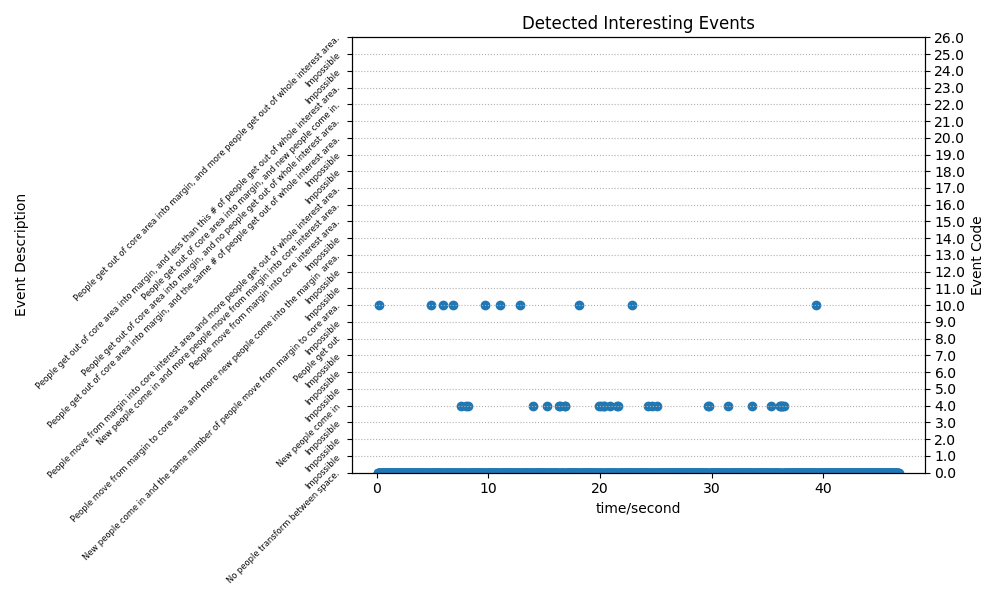

Processing frame: 0
Frame: 18, grabbed=False and frame=None
Frame: 19, grabbed=False and frame=None
Frame: 20, grabbed=False and frame=None
Frame: 21, grabbed=False and frame=None
Frame: 22, grabbed=False and frame=None
Frame: 23, grabbed=False and frame=None
Frame: 24, grabbed=False and frame=None
Frame: 25, grabbed=False and frame=None
Frame: 26, grabbed=False and frame=None
Frame: 27, grabbed=False and frame=None
Frame: 28, grabbed=False and frame=None
Frame: 29, grabbed=False and frame=None
Frame: 30, grabbed=False and frame=None
Frame: 31, grabbed=False and frame=None
Frame: 32, grabbed=False and frame=None
Frame: 33, grabbed=False and frame=None
Frame: 34, grabbed=False and frame=None
Frame: 35, grabbed=False and frame=None
Frame: 36, grabbed=False and frame=None
Frame: 37, grabbed=False and frame=None
Frame: 38, grabbed=False and frame=None
Frame: 39, grabbed=False and frame=None
Frame: 40, grabbed=False and frame=None
Frame: 41, grabbed=False and frame=None
Frame: 42, grabbed=F

Frame: 221, grabbed=False and frame=None
Frame: 222, grabbed=False and frame=None
Frame: 223, grabbed=False and frame=None
Frame: 224, grabbed=False and frame=None
Frame: 225, grabbed=False and frame=None
Frame: 226, grabbed=False and frame=None
Frame: 227, grabbed=False and frame=None
Frame: 228, grabbed=False and frame=None
Frame: 229, grabbed=False and frame=None
Frame: 230, grabbed=False and frame=None
Frame: 231, grabbed=False and frame=None
Frame: 232, grabbed=False and frame=None
Frame: 233, grabbed=False and frame=None
Frame: 234, grabbed=False and frame=None
Frame: 235, grabbed=False and frame=None
Frame: 236, grabbed=False and frame=None
Frame: 237, grabbed=False and frame=None
Frame: 238, grabbed=False and frame=None
Frame: 239, grabbed=False and frame=None
Frame: 240, grabbed=False and frame=None
Frame: 241, grabbed=False and frame=None
Frame: 242, grabbed=False and frame=None
Frame: 243, grabbed=False and frame=None
Frame: 244, grabbed=False and frame=None
Frame: 245, grab

Frame: 422, grabbed=False and frame=None
Frame: 423, grabbed=False and frame=None
Frame: 424, grabbed=False and frame=None
Frame: 425, grabbed=False and frame=None
Frame: 426, grabbed=False and frame=None
Frame: 427, grabbed=False and frame=None
Frame: 428, grabbed=False and frame=None
Frame: 429, grabbed=False and frame=None
Frame: 430, grabbed=False and frame=None
Frame: 431, grabbed=False and frame=None
Frame: 432, grabbed=False and frame=None
Frame: 433, grabbed=False and frame=None
Frame: 434, grabbed=False and frame=None
Frame: 435, grabbed=False and frame=None
Frame: 436, grabbed=False and frame=None
Frame: 437, grabbed=False and frame=None
Frame: 438, grabbed=False and frame=None
Frame: 439, grabbed=False and frame=None
Frame: 440, grabbed=False and frame=None
Frame: 441, grabbed=False and frame=None
Frame: 442, grabbed=False and frame=None
Frame: 443, grabbed=False and frame=None
Frame: 444, grabbed=False and frame=None
Frame: 445, grabbed=False and frame=None
Frame: 446, grab

Frame: 626, grabbed=False and frame=None
Frame: 627, grabbed=False and frame=None
Frame: 628, grabbed=False and frame=None
Frame: 629, grabbed=False and frame=None
Frame: 630, grabbed=False and frame=None
Frame: 631, grabbed=False and frame=None
Frame: 632, grabbed=False and frame=None
Frame: 633, grabbed=False and frame=None
Frame: 634, grabbed=False and frame=None
Frame: 635, grabbed=False and frame=None
Frame: 636, grabbed=False and frame=None
Frame: 637, grabbed=False and frame=None
Frame: 638, grabbed=False and frame=None
Frame: 639, grabbed=False and frame=None
Frame: 640, grabbed=False and frame=None
Frame: 641, grabbed=False and frame=None
Frame: 642, grabbed=False and frame=None
Frame: 643, grabbed=False and frame=None
Frame: 644, grabbed=False and frame=None
Frame: 645, grabbed=False and frame=None
Frame: 646, grabbed=False and frame=None
Frame: 647, grabbed=False and frame=None
Frame: 648, grabbed=False and frame=None
Frame: 649, grabbed=False and frame=None
Frame: 650, grab

Frame: 827, grabbed=False and frame=None
Frame: 828, grabbed=False and frame=None
Frame: 829, grabbed=False and frame=None
Frame: 830, grabbed=False and frame=None
Frame: 831, grabbed=False and frame=None
Frame: 832, grabbed=False and frame=None
Frame: 833, grabbed=False and frame=None
Frame: 834, grabbed=False and frame=None
Frame: 835, grabbed=False and frame=None
Frame: 836, grabbed=False and frame=None
Frame: 837, grabbed=False and frame=None
Frame: 838, grabbed=False and frame=None
Frame: 839, grabbed=False and frame=None
Frame: 840, grabbed=False and frame=None
Frame: 841, grabbed=False and frame=None
Frame: 842, grabbed=False and frame=None
Frame: 843, grabbed=False and frame=None
Frame: 844, grabbed=False and frame=None
Frame: 845, grabbed=False and frame=None
Frame: 846, grabbed=False and frame=None
Frame: 847, grabbed=False and frame=None
Frame: 848, grabbed=False and frame=None
Frame: 849, grabbed=False and frame=None
Frame: 850, grabbed=False and frame=None
Frame: 851, grab

Frame: 1030, grabbed=False and frame=None
Frame: 1031, grabbed=False and frame=None
Frame: 1032, grabbed=False and frame=None
Frame: 1033, grabbed=False and frame=None
Frame: 1034, grabbed=False and frame=None
Frame: 1035, grabbed=False and frame=None
Frame: 1036, grabbed=False and frame=None
Frame: 1037, grabbed=False and frame=None
Frame: 1038, grabbed=False and frame=None
Frame: 1039, grabbed=False and frame=None
Frame: 1040, grabbed=False and frame=None
Frame: 1041, grabbed=False and frame=None
Frame: 1042, grabbed=False and frame=None
Frame: 1043, grabbed=False and frame=None
Frame: 1044, grabbed=False and frame=None
Frame: 1045, grabbed=False and frame=None
Frame: 1046, grabbed=False and frame=None
Frame: 1047, grabbed=False and frame=None
Frame: 1048, grabbed=False and frame=None
Frame: 1049, grabbed=False and frame=None
Frame: 1050, grabbed=False and frame=None
Frame: 1051, grabbed=False and frame=None
Frame: 1052, grabbed=False and frame=None
Frame: 1053, grabbed=False and fra

Frame: 1226, grabbed=False and frame=None
Frame: 1227, grabbed=False and frame=None
Frame: 1228, grabbed=False and frame=None
Frame: 1229, grabbed=False and frame=None
Frame: 1230, grabbed=False and frame=None
Frame: 1231, grabbed=False and frame=None
Frame: 1232, grabbed=False and frame=None
Frame: 1233, grabbed=False and frame=None
Frame: 1234, grabbed=False and frame=None
Frame: 1235, grabbed=False and frame=None
Frame: 1236, grabbed=False and frame=None
Frame: 1237, grabbed=False and frame=None
Frame: 1238, grabbed=False and frame=None
Frame: 1239, grabbed=False and frame=None
Frame: 1240, grabbed=False and frame=None
Frame: 1241, grabbed=False and frame=None
Frame: 1242, grabbed=False and frame=None
Frame: 1243, grabbed=False and frame=None
Frame: 1244, grabbed=False and frame=None
Frame: 1245, grabbed=False and frame=None
Frame: 1246, grabbed=False and frame=None
Frame: 1247, grabbed=False and frame=None
Frame: 1248, grabbed=False and frame=None
Frame: 1249, grabbed=False and fra

In [18]:
# Smoothen
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)
# Interpret
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, 
                                                                 smooth_occupancy_margin, 
                                                                 smooth_occupancy_whole, 
                                                                 senarios_truth_table)
# Plot
fig_filename = 'Plot_Interesting_Event_smooth_type_{}_window_size_{}_stride{}'.format(smooth_type, window_size, stride)
plot_detected_interesting_event(senario_sequence, event_sequence, event_time, fig_filename)
# Tag
video_filename = './test_video_processed_whole.avi'
tag_interesting_event_description_on_video(video_filename, 
                                           smooth_type, window_size, stride,
                                           senario_sequence, event_sequence, event_time)

In [19]:
interesting_event_count = 1
for time_index, time in enumerate(event_time):
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,time/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.16666316526610644s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 4.833231792717087s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 5.899876050420168s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 6.799857142857143s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 7.533175070028012s
Explanation: New people come in
*****************************************************
Detected interesting event: 6

### min
To check the tagged video, please go to YouTube: [window_size = 25
smooth_type='min'
stride = 10](https://youtu.be/tS16whMEZkI)

In [20]:
window_size = 25
smooth_type='min'
stride = 10

<IPython.core.display.Javascript object>


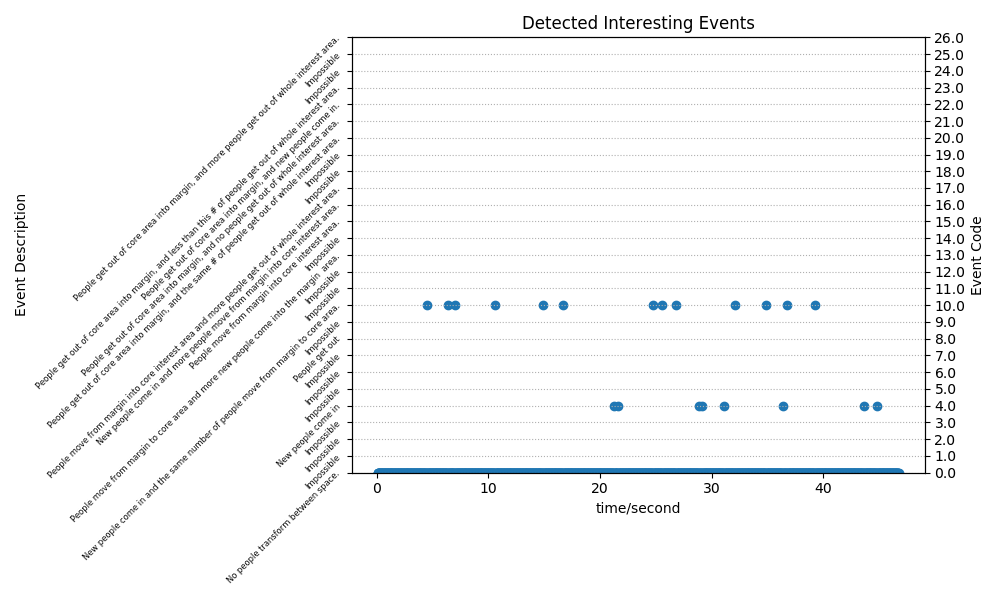

Processing frame: 0
Frame: 18, grabbed=False and frame=None
Frame: 19, grabbed=False and frame=None
Frame: 20, grabbed=False and frame=None
Frame: 21, grabbed=False and frame=None
Frame: 22, grabbed=False and frame=None
Frame: 23, grabbed=False and frame=None
Frame: 24, grabbed=False and frame=None
Frame: 25, grabbed=False and frame=None
Frame: 26, grabbed=False and frame=None
Frame: 27, grabbed=False and frame=None
Frame: 28, grabbed=False and frame=None
Frame: 29, grabbed=False and frame=None
Frame: 30, grabbed=False and frame=None
Frame: 31, grabbed=False and frame=None
Frame: 32, grabbed=False and frame=None
Frame: 33, grabbed=False and frame=None
Frame: 34, grabbed=False and frame=None
Frame: 35, grabbed=False and frame=None
Frame: 36, grabbed=False and frame=None
Frame: 37, grabbed=False and frame=None
Frame: 38, grabbed=False and frame=None
Frame: 39, grabbed=False and frame=None
Frame: 40, grabbed=False and frame=None
Frame: 41, grabbed=False and frame=None
Frame: 42, grabbed=F

Frame: 221, grabbed=False and frame=None
Frame: 222, grabbed=False and frame=None
Frame: 223, grabbed=False and frame=None
Frame: 224, grabbed=False and frame=None
Frame: 225, grabbed=False and frame=None
Frame: 226, grabbed=False and frame=None
Frame: 227, grabbed=False and frame=None
Frame: 228, grabbed=False and frame=None
Frame: 229, grabbed=False and frame=None
Frame: 230, grabbed=False and frame=None
Frame: 231, grabbed=False and frame=None
Frame: 232, grabbed=False and frame=None
Frame: 233, grabbed=False and frame=None
Frame: 234, grabbed=False and frame=None
Frame: 235, grabbed=False and frame=None
Frame: 236, grabbed=False and frame=None
Frame: 237, grabbed=False and frame=None
Frame: 238, grabbed=False and frame=None
Frame: 239, grabbed=False and frame=None
Frame: 240, grabbed=False and frame=None
Frame: 241, grabbed=False and frame=None
Frame: 242, grabbed=False and frame=None
Frame: 243, grabbed=False and frame=None
Frame: 244, grabbed=False and frame=None
Frame: 245, grab

Frame: 422, grabbed=False and frame=None
Frame: 423, grabbed=False and frame=None
Frame: 424, grabbed=False and frame=None
Frame: 425, grabbed=False and frame=None
Frame: 426, grabbed=False and frame=None
Frame: 427, grabbed=False and frame=None
Frame: 428, grabbed=False and frame=None
Frame: 429, grabbed=False and frame=None
Frame: 430, grabbed=False and frame=None
Frame: 431, grabbed=False and frame=None
Frame: 432, grabbed=False and frame=None
Frame: 433, grabbed=False and frame=None
Frame: 434, grabbed=False and frame=None
Frame: 435, grabbed=False and frame=None
Frame: 436, grabbed=False and frame=None
Frame: 437, grabbed=False and frame=None
Frame: 438, grabbed=False and frame=None
Frame: 439, grabbed=False and frame=None
Frame: 440, grabbed=False and frame=None
Frame: 441, grabbed=False and frame=None
Frame: 442, grabbed=False and frame=None
Frame: 443, grabbed=False and frame=None
Frame: 444, grabbed=False and frame=None
Frame: 445, grabbed=False and frame=None
Frame: 446, grab

Frame: 627, grabbed=False and frame=None
Frame: 628, grabbed=False and frame=None
Frame: 629, grabbed=False and frame=None
Frame: 630, grabbed=False and frame=None
Frame: 631, grabbed=False and frame=None
Frame: 632, grabbed=False and frame=None
Frame: 633, grabbed=False and frame=None
Frame: 634, grabbed=False and frame=None
Frame: 635, grabbed=False and frame=None
Frame: 636, grabbed=False and frame=None
Frame: 637, grabbed=False and frame=None
Frame: 638, grabbed=False and frame=None
Frame: 639, grabbed=False and frame=None
Frame: 640, grabbed=False and frame=None
Frame: 641, grabbed=False and frame=None
Frame: 642, grabbed=False and frame=None
Frame: 643, grabbed=False and frame=None
Frame: 644, grabbed=False and frame=None
Frame: 645, grabbed=False and frame=None
Frame: 646, grabbed=False and frame=None
Frame: 647, grabbed=False and frame=None
Frame: 648, grabbed=False and frame=None
Frame: 649, grabbed=False and frame=None
Frame: 650, grabbed=False and frame=None
Frame: 651, grab

Frame: 828, grabbed=False and frame=None
Frame: 829, grabbed=False and frame=None
Frame: 830, grabbed=False and frame=None
Frame: 831, grabbed=False and frame=None
Frame: 832, grabbed=False and frame=None
Frame: 833, grabbed=False and frame=None
Frame: 834, grabbed=False and frame=None
Frame: 835, grabbed=False and frame=None
Frame: 836, grabbed=False and frame=None
Frame: 837, grabbed=False and frame=None
Frame: 838, grabbed=False and frame=None
Frame: 839, grabbed=False and frame=None
Frame: 840, grabbed=False and frame=None
Frame: 841, grabbed=False and frame=None
Frame: 842, grabbed=False and frame=None
Frame: 843, grabbed=False and frame=None
Frame: 844, grabbed=False and frame=None
Frame: 845, grabbed=False and frame=None
Frame: 846, grabbed=False and frame=None
Frame: 847, grabbed=False and frame=None
Frame: 848, grabbed=False and frame=None
Frame: 849, grabbed=False and frame=None
Frame: 850, grabbed=False and frame=None
Frame: 851, grabbed=False and frame=None
Frame: 852, grab

Frame: 1034, grabbed=False and frame=None
Frame: 1035, grabbed=False and frame=None
Frame: 1036, grabbed=False and frame=None
Frame: 1037, grabbed=False and frame=None
Frame: 1038, grabbed=False and frame=None
Frame: 1039, grabbed=False and frame=None
Frame: 1040, grabbed=False and frame=None
Frame: 1041, grabbed=False and frame=None
Frame: 1042, grabbed=False and frame=None
Frame: 1043, grabbed=False and frame=None
Frame: 1044, grabbed=False and frame=None
Frame: 1045, grabbed=False and frame=None
Frame: 1046, grabbed=False and frame=None
Frame: 1047, grabbed=False and frame=None
Frame: 1048, grabbed=False and frame=None
Frame: 1049, grabbed=False and frame=None
Frame: 1050, grabbed=False and frame=None
Frame: 1051, grabbed=False and frame=None
Frame: 1052, grabbed=False and frame=None
Frame: 1053, grabbed=False and frame=None
Frame: 1054, grabbed=False and frame=None
Frame: 1055, grabbed=False and frame=None
Frame: 1056, grabbed=False and frame=None
Frame: 1057, grabbed=False and fra

Frame: 1236, grabbed=False and frame=None
Frame: 1237, grabbed=False and frame=None
Frame: 1238, grabbed=False and frame=None
Frame: 1239, grabbed=False and frame=None
Frame: 1240, grabbed=False and frame=None
Frame: 1241, grabbed=False and frame=None
Frame: 1242, grabbed=False and frame=None
Frame: 1243, grabbed=False and frame=None
Frame: 1244, grabbed=False and frame=None
Frame: 1245, grabbed=False and frame=None
Frame: 1246, grabbed=False and frame=None
Frame: 1247, grabbed=False and frame=None
Frame: 1248, grabbed=False and frame=None
Frame: 1249, grabbed=False and frame=None
Frame: 1250, grabbed=False and frame=None
Frame: 1251, grabbed=False and frame=None
Frame: 1252, grabbed=False and frame=None
Frame: 1253, grabbed=False and frame=None
Frame: 1254, grabbed=False and frame=None
Frame: 1255, grabbed=False and frame=None
Frame: 1256, grabbed=False and frame=None
Frame: 1257, grabbed=False and frame=None
Frame: 1258, grabbed=False and frame=None
Frame: 1259, grabbed=False and fra

In [21]:
# Smoothen
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)
# Interpret
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, 
                                                                 smooth_occupancy_margin, 
                                                                 smooth_occupancy_whole, 
                                                                 senarios_truth_table)
# Plot
fig_filename = 'Plot_Interesting_Event_smooth_type_{}_window_size_{}_stride{}'.format(smooth_type, window_size, stride)
plot_detected_interesting_event(senario_sequence, event_sequence, event_time, fig_filename)
# Tag
video_filename = './test_video_processed_whole.avi'
tag_interesting_event_description_on_video(video_filename, 
                                           smooth_type, window_size, stride,
                                           senario_sequence, event_sequence, event_time)

In [22]:
interesting_event_count = 1
for time_index, time in enumerate(event_time):
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,time/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 4.5332380952380955s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 6.333200280112044s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 6.999852941176469s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 10.59977731092437s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 14.866354341736697s
Explanation: New people come in and the same number of people move from margin to core area.
**********************

### median
To check the tagged video, please go to YouTube: [window_size = 25
smooth_type='median'
stride = 10](https://youtu.be/xINbeHZbyiA).

In [23]:
window_size = 25
smooth_type='median'
stride = 10

<IPython.core.display.Javascript object>


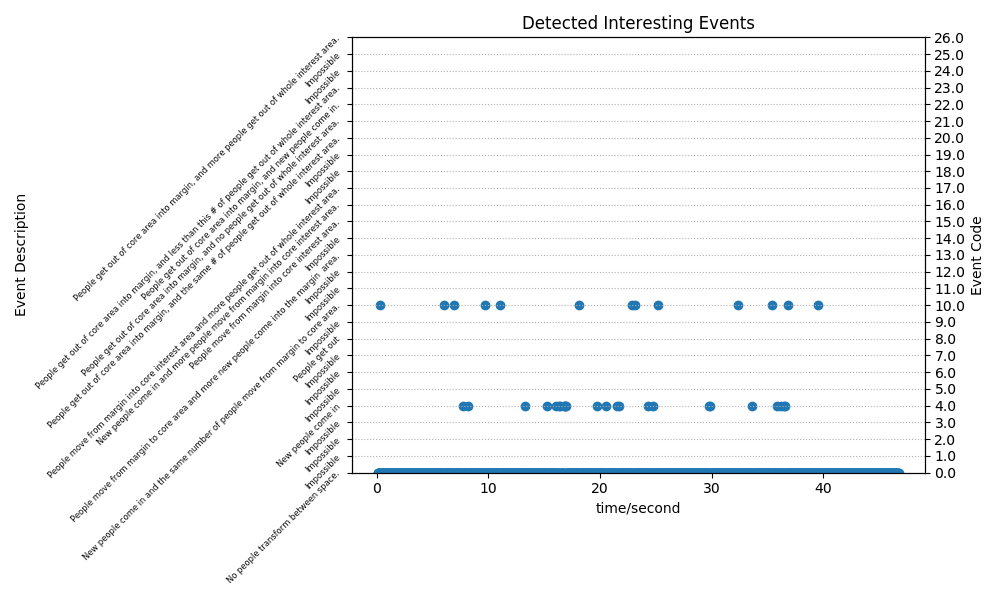

Processing frame: 0
Frame: 18, grabbed=False and frame=None
Frame: 19, grabbed=False and frame=None
Frame: 20, grabbed=False and frame=None
Frame: 21, grabbed=False and frame=None
Frame: 22, grabbed=False and frame=None
Frame: 23, grabbed=False and frame=None
Frame: 24, grabbed=False and frame=None
Frame: 25, grabbed=False and frame=None
Frame: 26, grabbed=False and frame=None
Frame: 27, grabbed=False and frame=None
Frame: 28, grabbed=False and frame=None
Frame: 29, grabbed=False and frame=None
Frame: 30, grabbed=False and frame=None
Frame: 31, grabbed=False and frame=None
Frame: 32, grabbed=False and frame=None
Frame: 33, grabbed=False and frame=None
Frame: 34, grabbed=False and frame=None
Frame: 35, grabbed=False and frame=None
Frame: 36, grabbed=False and frame=None
Frame: 37, grabbed=False and frame=None
Frame: 38, grabbed=False and frame=None
Frame: 39, grabbed=False and frame=None
Frame: 40, grabbed=False and frame=None
Frame: 41, grabbed=False and frame=None
Frame: 42, grabbed=F

Frame: 224, grabbed=False and frame=None
Frame: 225, grabbed=False and frame=None
Frame: 226, grabbed=False and frame=None
Frame: 227, grabbed=False and frame=None
Frame: 228, grabbed=False and frame=None
Frame: 229, grabbed=False and frame=None
Frame: 230, grabbed=False and frame=None
Frame: 231, grabbed=False and frame=None
Frame: 232, grabbed=False and frame=None
Frame: 233, grabbed=False and frame=None
Frame: 234, grabbed=False and frame=None
Frame: 235, grabbed=False and frame=None
Frame: 236, grabbed=False and frame=None
Frame: 237, grabbed=False and frame=None
Frame: 238, grabbed=False and frame=None
Frame: 239, grabbed=False and frame=None
Frame: 240, grabbed=False and frame=None
Frame: 241, grabbed=False and frame=None
Frame: 242, grabbed=False and frame=None
Frame: 243, grabbed=False and frame=None
Frame: 244, grabbed=False and frame=None
Frame: 245, grabbed=False and frame=None
Frame: 246, grabbed=False and frame=None
Frame: 247, grabbed=False and frame=None
Frame: 248, grab

Frame: 430, grabbed=False and frame=None
Frame: 431, grabbed=False and frame=None
Frame: 432, grabbed=False and frame=None
Frame: 433, grabbed=False and frame=None
Frame: 434, grabbed=False and frame=None
Frame: 435, grabbed=False and frame=None
Frame: 436, grabbed=False and frame=None
Frame: 437, grabbed=False and frame=None
Frame: 438, grabbed=False and frame=None
Frame: 439, grabbed=False and frame=None
Frame: 440, grabbed=False and frame=None
Frame: 441, grabbed=False and frame=None
Frame: 442, grabbed=False and frame=None
Frame: 443, grabbed=False and frame=None
Frame: 444, grabbed=False and frame=None
Frame: 445, grabbed=False and frame=None
Frame: 446, grabbed=False and frame=None
Frame: 447, grabbed=False and frame=None
Frame: 448, grabbed=False and frame=None
Frame: 449, grabbed=False and frame=None
Frame: 450, grabbed=False and frame=None
Frame: 451, grabbed=False and frame=None
Frame: 452, grabbed=False and frame=None
Frame: 453, grabbed=False and frame=None
Frame: 454, grab

Frame: 631, grabbed=False and frame=None
Frame: 632, grabbed=False and frame=None
Frame: 633, grabbed=False and frame=None
Frame: 634, grabbed=False and frame=None
Frame: 635, grabbed=False and frame=None
Frame: 636, grabbed=False and frame=None
Frame: 637, grabbed=False and frame=None
Frame: 638, grabbed=False and frame=None
Frame: 639, grabbed=False and frame=None
Frame: 640, grabbed=False and frame=None
Frame: 641, grabbed=False and frame=None
Frame: 642, grabbed=False and frame=None
Frame: 643, grabbed=False and frame=None
Frame: 644, grabbed=False and frame=None
Frame: 645, grabbed=False and frame=None
Frame: 646, grabbed=False and frame=None
Frame: 647, grabbed=False and frame=None
Frame: 648, grabbed=False and frame=None
Frame: 649, grabbed=False and frame=None
Frame: 650, grabbed=False and frame=None
Frame: 651, grabbed=False and frame=None
Frame: 652, grabbed=False and frame=None
Frame: 653, grabbed=False and frame=None
Frame: 654, grabbed=False and frame=None
Frame: 655, grab

Frame: 832, grabbed=False and frame=None
Frame: 833, grabbed=False and frame=None
Frame: 834, grabbed=False and frame=None
Frame: 835, grabbed=False and frame=None
Frame: 836, grabbed=False and frame=None
Frame: 837, grabbed=False and frame=None
Frame: 838, grabbed=False and frame=None
Frame: 839, grabbed=False and frame=None
Frame: 840, grabbed=False and frame=None
Frame: 841, grabbed=False and frame=None
Frame: 842, grabbed=False and frame=None
Frame: 843, grabbed=False and frame=None
Frame: 844, grabbed=False and frame=None
Frame: 845, grabbed=False and frame=None
Frame: 846, grabbed=False and frame=None
Frame: 847, grabbed=False and frame=None
Frame: 848, grabbed=False and frame=None
Frame: 849, grabbed=False and frame=None
Frame: 850, grabbed=False and frame=None
Frame: 851, grabbed=False and frame=None
Frame: 852, grabbed=False and frame=None
Frame: 853, grabbed=False and frame=None
Frame: 854, grabbed=False and frame=None
Frame: 855, grabbed=False and frame=None
Frame: 856, grab

Frame: 1036, grabbed=False and frame=None
Frame: 1037, grabbed=False and frame=None
Frame: 1038, grabbed=False and frame=None
Frame: 1039, grabbed=False and frame=None
Frame: 1040, grabbed=False and frame=None
Frame: 1041, grabbed=False and frame=None
Frame: 1042, grabbed=False and frame=None
Frame: 1043, grabbed=False and frame=None
Frame: 1044, grabbed=False and frame=None
Frame: 1045, grabbed=False and frame=None
Frame: 1046, grabbed=False and frame=None
Frame: 1047, grabbed=False and frame=None
Frame: 1048, grabbed=False and frame=None
Frame: 1049, grabbed=False and frame=None
Frame: 1050, grabbed=False and frame=None
Frame: 1051, grabbed=False and frame=None
Frame: 1052, grabbed=False and frame=None
Frame: 1053, grabbed=False and frame=None
Frame: 1054, grabbed=False and frame=None
Frame: 1055, grabbed=False and frame=None
Frame: 1056, grabbed=False and frame=None
Frame: 1057, grabbed=False and frame=None
Frame: 1058, grabbed=False and frame=None
Frame: 1059, grabbed=False and fra

Frame: 1234, grabbed=False and frame=None
Frame: 1235, grabbed=False and frame=None
Frame: 1236, grabbed=False and frame=None
Frame: 1237, grabbed=False and frame=None
Frame: 1238, grabbed=False and frame=None
Frame: 1239, grabbed=False and frame=None
Frame: 1240, grabbed=False and frame=None
Frame: 1241, grabbed=False and frame=None
Frame: 1242, grabbed=False and frame=None
Frame: 1243, grabbed=False and frame=None
Frame: 1244, grabbed=False and frame=None
Frame: 1245, grabbed=False and frame=None
Frame: 1246, grabbed=False and frame=None
Frame: 1247, grabbed=False and frame=None
Frame: 1248, grabbed=False and frame=None
Frame: 1249, grabbed=False and frame=None
Frame: 1250, grabbed=False and frame=None
Frame: 1251, grabbed=False and frame=None
Frame: 1252, grabbed=False and frame=None
Frame: 1253, grabbed=False and frame=None
Frame: 1254, grabbed=False and frame=None
Frame: 1255, grabbed=False and frame=None
Frame: 1256, grabbed=False and frame=None
Frame: 1257, grabbed=False and fra

In [24]:
# Smoothen
smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)
# Interpret
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, 
                                                                 smooth_occupancy_margin, 
                                                                 smooth_occupancy_whole, 
                                                                 senarios_truth_table)
# Plot
fig_filename = 'Plot_Interesting_Event_smooth_type_{}_window_size_{}_stride{}'.format(smooth_type, window_size, stride)
plot_detected_interesting_event(senario_sequence, event_sequence, event_time, fig_filename)
# Tag
video_filename = './test_video_processed_whole.avi'
tag_interesting_event_description_on_video(video_filename, 
                                           smooth_type, window_size, stride,
                                           senario_sequence, event_sequence, event_time)

In [25]:
interesting_event_count = 1
for time_index, time in enumerate(event_time):
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,time/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.2666610644257703s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 5.999873949579832s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 6.8998550420168066s
Explanation: New people come in and the same number of people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 7.699838235294117s
Explanation: New people come in
*****************************************************
Detected interesting event: 5,    Time: 8.166495098039215s
Explanation: New people come in
*****************************************************
Detected interesting event: 6,    Time: 9.699796218487396s
Explanation: New people come in

# Check on Video
To check the video, please go to [YouTube: test video processed](https://youtu.be/1iPKDs9P1i4).
1. If we look at the video, we might find that moving from one interesting area to another for people might take less than one second or even less than half second.
2. One big probelm is the estimation results from Openpose is not so reliable.